In [1]:
import pickle
import numpy as np
import dask.array as da
from dask.array.core import normalize_chunks
from skimage.io import imread
from scipy.ndimage import affine_transform
from utils.imutils import *
import napari
from napari.utils import nbscreenshot
from skimage.transform import AffineTransform
from skimage import img_as_ubyte
import time

In [2]:
%gui qt

In [3]:
time.sleep(1)
v=napari.Viewer()

2021-06-23 22:28:10,542 [INFO] WRITING LOG OUTPUT TO /home/hilsenst/.cellpose/run.log


In [4]:
with open("chunk_tiles_dict.pickle", "rb") as f:
    chunk_tiles = pickle.load(f)

In [5]:
chunk_tiles

{(12000,
  12000): [('Well1_Seq0001_1_0001',
   array([[1.00000000e+00, 0.00000000e+00, 1.30496875e+04],
          [0.00000000e+00, 1.00000000e+00, 1.30875000e+04],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('Well1_Seq0001_1_0002',
   array([[1.00000000e+00, 0.00000000e+00, 1.11959375e+04],
          [0.00000000e+00, 1.00000000e+00, 1.30979688e+04],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('Well1_Seq0001_1_0015',
   array([[1.00000000e+00, 0.00000000e+00, 1.11853125e+04],
          [0.00000000e+00, 1.00000000e+00, 1.12298438e+04],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('Well1_Seq0001_1_0016',
   array([[1.00000000e+00, 0.00000000e+00, 1.30390625e+04],
          [0.00000000e+00, 1.00000000e+00, 1.12193750e+04],
          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])), ('Well1_Seq0001_1_0017',
   array([[1.00000000e+00, 0.00000000e+00, 1.48926562e+04],
          [0.00000000e+00, 1.00000000e+00, 1.12087500e+04],
   

In [6]:
stitched_shape = (16937, 15210)
stitched_chunk_size = (4000,4000)

In [7]:
def fuse(input_tile_info, block_info=None):
    array_location = block_info[None]['array-location']
    anchor_point = (array_location[0][0], array_location[1][0])

    chunk_shape = block_info[None]['chunk-shape']
    tiles_info = input_tile_info[anchor_point]
    fused = np.zeros(chunk_shape, dtype=np.uint8)
    empty = True
    for tile_fname, tile_affine in tiles_info:
        im = load_image(Path("./Stiching_Example_Dataset/") / f"{tile_fname}.jpg")
        im = transpose(select_channel(crop_black_border(im),0))[...,0]
        shift = AffineTransform(translation=(-anchor_point[0], -anchor_point[1]))
        tile_shifted = affine_transform(im, matrix=np.linalg.inv(tile_affine@shift), output_shape=chunk_shape) #,offset=(anchor_point[0], anchor_point[1]))
        if np.any(tile_shifted):
            empty = False
        stack = np.stack([fused,tile_shifted])
        print(tile_fname, anchor_point, stack.shape, empty)
        fused = np.max(stack,axis=0)
    return fused

In [8]:
target_array = da.map_blocks(func=fuse,
                             chunks=normalize_chunks(stitched_chunk_size, stitched_shape), 
                             input_tile_info=chunk_tiles,
                             dtype=np.uint8)

In [9]:
target_array.to_zarr("fused.zarr", overwrite=True)

Well1_Seq0001_1_0006 (0, 12000) (2, 4000, 3210) False
Well1_Seq0001_1_0004 (4000, 12000) (2, 4000, 3210) False
Well1_Seq0001_1_0002 (8000, 12000) (2, 4000, 3210) False
Well1_Seq0001_1_0049 (8000, 0) (2, 4000, 4000) False
Well1_Seq0001_1_0047 (4000, 0) (2, 4000, 4000) False
Well1_Seq0001_1_0029Well1_Seq0001_1_0013 (8000, 8000) (2, 4000, 4000) False
 (4000, 4000) (2, 4000, 4000) False
Well1_Seq0001_1_0045 (0, 0) (2, 4000, 4000) False
Well1_Seq0001_1_0031 (8000, 4000) (2, 4000, 4000) False
Well1_Seq0001_1_0009 (0, 8000) (2, 4000, 4000) False
Well1_Seq0001_1_0027 (0, 4000) (2, 4000, 4000) False
Well1_Seq0001_1_0011 (4000, 8000) (2, 4000, 4000) False
Well1_Seq0001_1_0048 (4000, 0) (2, 4000, 4000) False
Well1_Seq0001_1_0030 (4000, 4000) (2, 4000, 4000) False
Well1_Seq0001_1_0050 (8000, 0) (2, 4000, 4000) False
Well1_Seq0001_1_0005 (4000, 12000) (2, 4000, 3210) False
Well1_Seq0001_1_0046Well1_Seq0001_1_0007 (0, 12000) (2, 4000, 3210) False
 (0, 0) (2, 4000, 4000) False
Well1_Seq0001_1_0014 (8

In [10]:
time.sleep(1)
v.add_image(da.from_zarr("fused.zarr"))

<Image layer 'Image' at 0x7fc8d5e34b10>

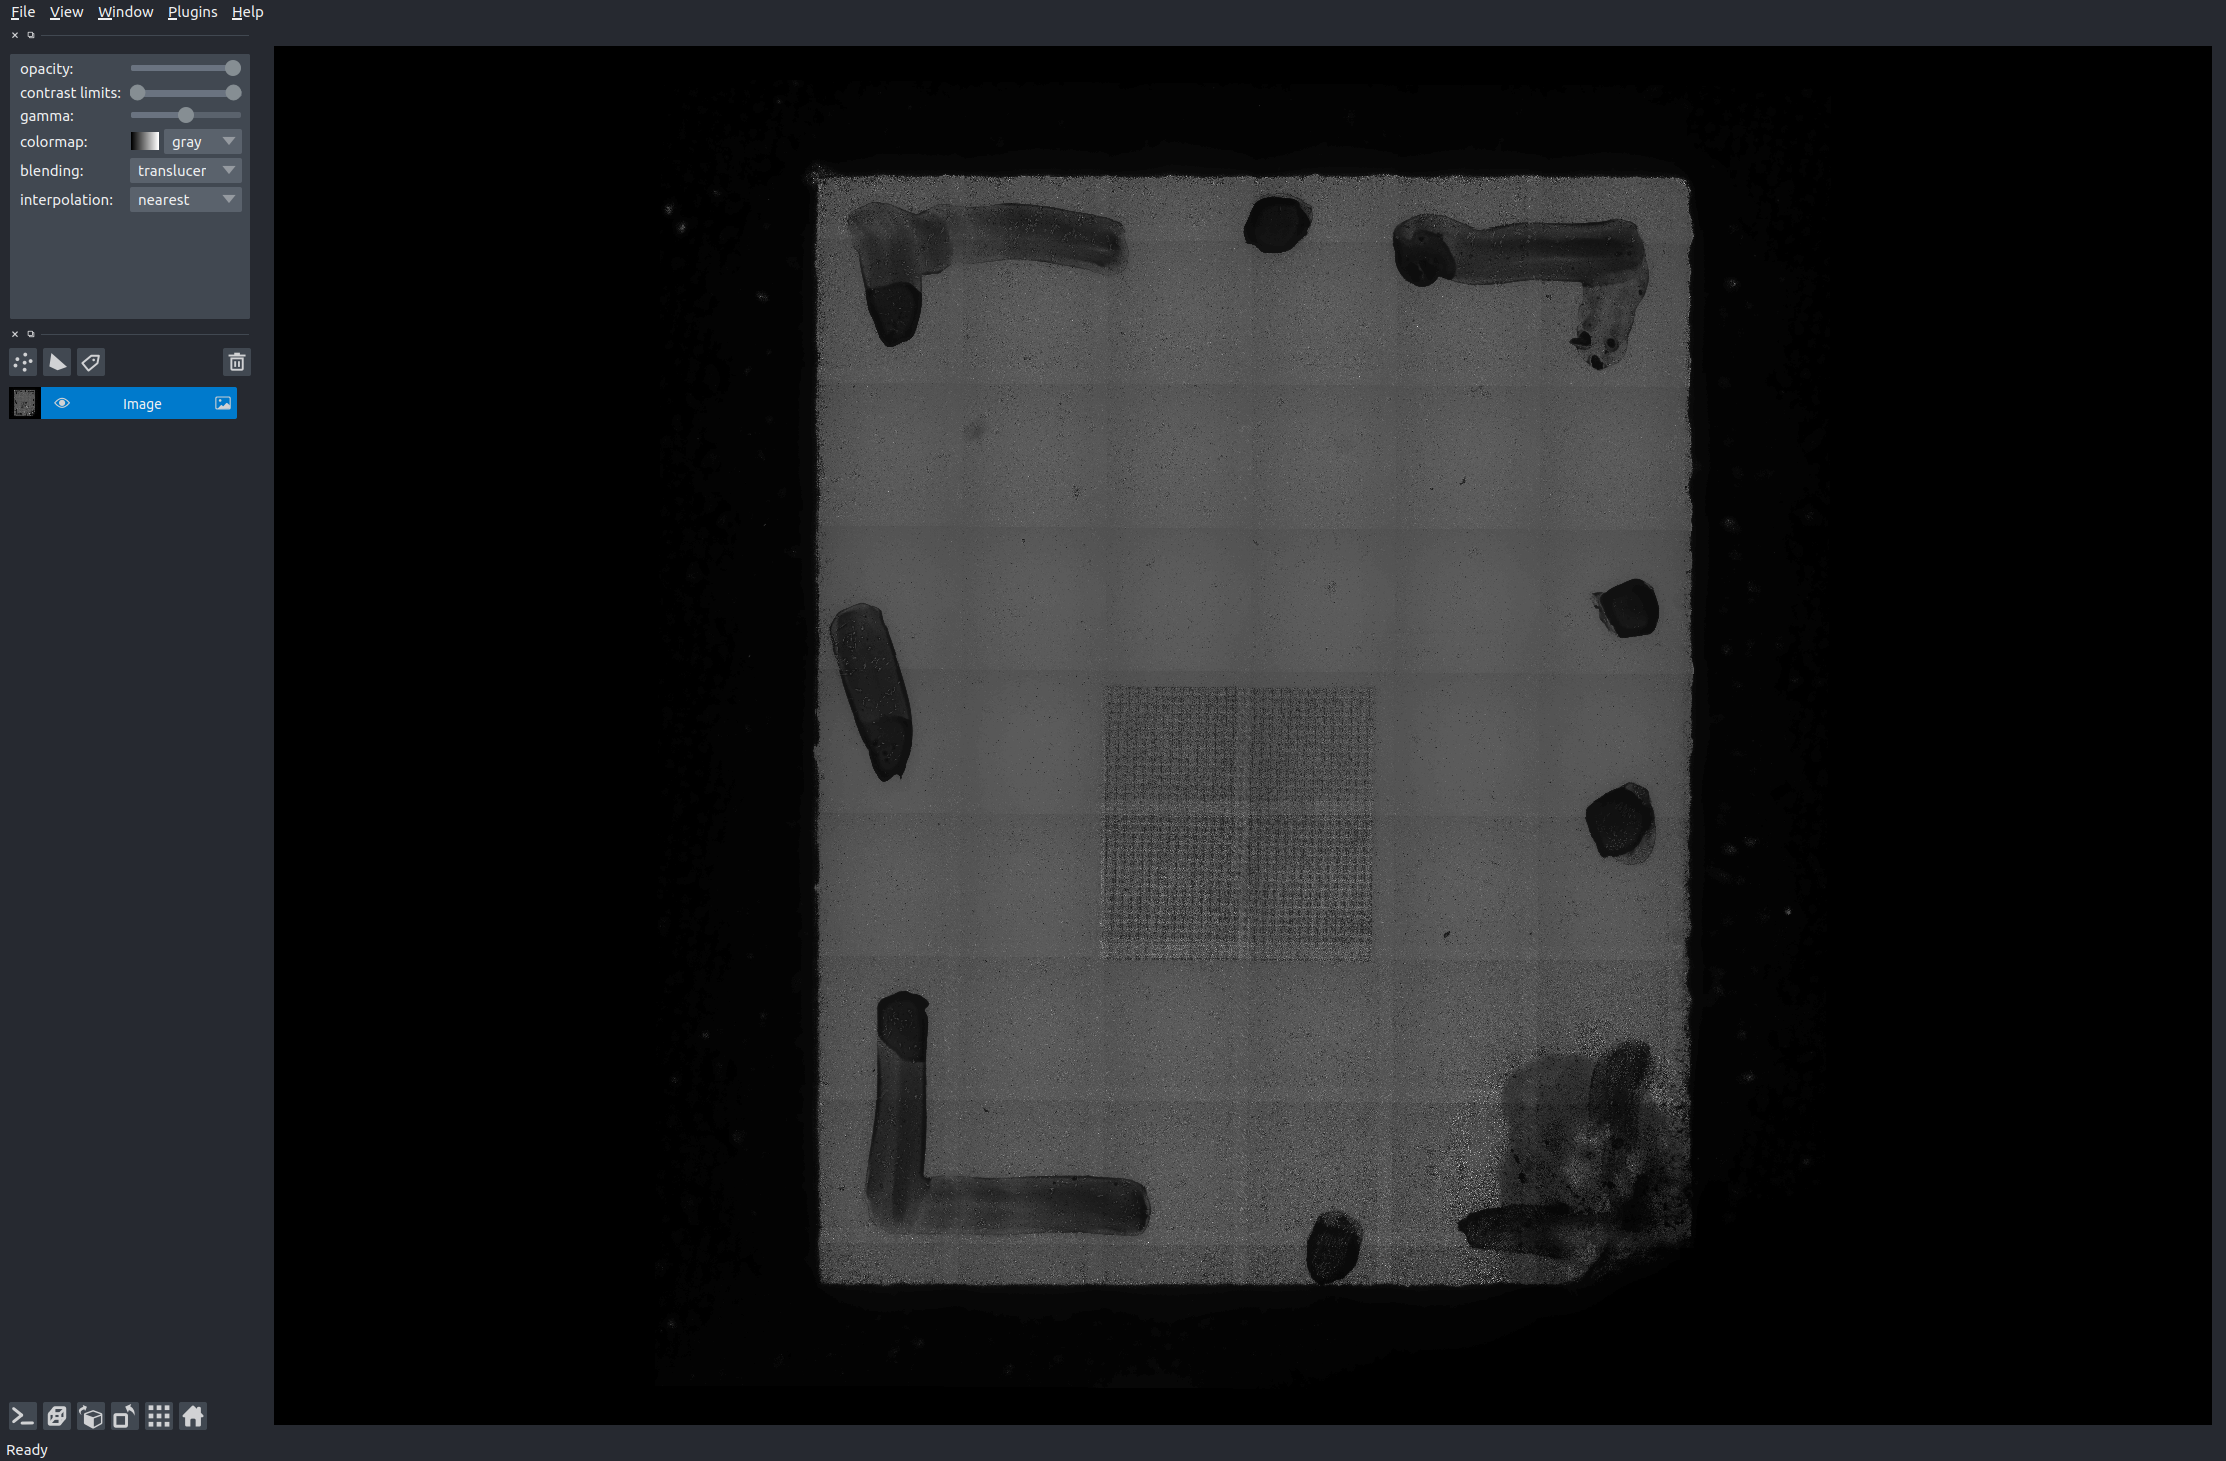

In [11]:
nbscreenshot(v)